In [41]:
#I made the workflow in a little notebook so the parameters are all here and its traceable.
#If you want to play around with it, it'll prob take some time since getting everything installed
#and woprking is a pain


In [ ]:
import subprocess
import shlex

def runHHblits( aln , name, path , outdir, db , iterations , ncores , runName='' , SS= False  , ohhm = False , verbose = True , Z = 2000 , B = 2000 , xargs = ' -cons '):
    if verbose == True:
        print( [aln , name, path , outdir, db , iterations , ncores , runName] )
    
    outhhr= outdir+name+runName+".hhr"
    args = path + ' -cpu '+ str(ncores) +' -d ' + db + ' -i ' + aln  +' -o '+ outhhr + ' -n ' + str(iterations) + ' -B '+ str(B) + ' -Z ' + str(Z) +' '+ xargs 
    if SS == True:
         args += ' -ssm 2 -ssw .5 '
    
    if ohhm == True:
        outa3m = outdir+name+runName+'.a3m'
        args += ' -Oa3m ' + outa3m
    else: 
        outa3m = None
    if verbose == True:
        print(args)
    
    args = shlex.split( args)
    p = subprocess.run( args )
    return p , [outhhr,outa3m]

In [27]:
#run hhblits
p, outfiles = runHHblits( './HOG25968.1.aln' , 'HOG25968' , 'hhblits', outdir = './' , db ='/home/cactuskid13/mntpt/HHBLITsdb/pdb70/pdb70' , ohhm = True,  iterations = 1 , ncores = 8 , )
print(outfiles)


['./HOG25968.1.aln', 'HOG25968', 'hhblits', './', '/home/cactuskid13/mntpt/HHBLITsdb/pdb70/pdb70', 1, 8, '']
hhblits -cpu 8 -d /home/cactuskid13/mntpt/HHBLITsdb/pdb70/pdb70 -i ./HOG25968.1.aln -o ./HOG25968.hhr -n 1 -B 2000 -Z 2000  -cons  -Oa3m ./HOG25968.a3m
['./HOG25968.hhr', './HOG25968.a3m']


In [28]:
#parse results

import csb
import pandas as pd 

from csb.bio.io.hhpred import HHOutputParser
results = HHOutputParser(alignments=False).parse_file(outfiles[0])

newhits = {}
hitlist=[]
for hit in results:
    hitlist.append(hit.id)
    newhits.update( {  hit.id : { 'prob':hit.probability, 'len' : hit.length , 'score': hit.score   , 'start':hit.start , 'stop':hit.end }}  )
      
hhdf = pd.DataFrame.from_dict(newhits, orient = 'index')
hhdf['model'] = hhdf.index.map(lambda x : x.split('_')[0])
hhdf['chain'] = hhdf.index.map(lambda x : x.split('_')[1])

print(hhdf.head())



         prob  len  score  start  stop model chain
1A77_A  0.994  182  165.6      1   182  1A77     A
1B43_B  0.995  181  178.8      1   181  1B43     B
1BGX_T  0.985  146  136.1      5   150  1BGX     T
1CMW_A  0.987  144  140.9      8   151  1CMW     A
1HUX_B  0.980  230   95.5      2   231  1HUX     B


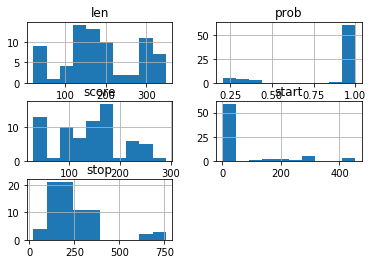

structure subset


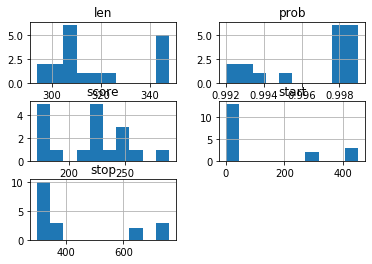

         prob  len  score  start  stop model chain
2IVN_A  0.998  307  226.2      2   308  2IVN     A
2IVP_A  0.998  307  226.2      2   308  2IVP     A
2VWB_A  0.999  299  248.9      2   300  2VWB     A
3EN9_A  0.999  301  245.3      5   305  3EN9     A
3ENO_A  0.998  309  221.5      3   311  3ENO     A
3ENO_B  0.998  309  221.5      3   311  3ENO     B
3TTC_A  0.994  347  180.5    303   649  3TTC     A
3TTD_A  0.992  347  171.9    303   649  3TTD     A
3VEN_A  0.995  346  190.2     12   357  3VEN     A
3VTH_A  0.992  294  171.2    453   746  3VTH     A
3WUH_B  0.999  348  255.2      6   353  3WUH     B
3ZEU_B  0.998  322  214.2      2   323  3ZEU     B
4G9I_A  0.993  307  179.7    452   758  4G9I     A
4G9I_F  0.993  307  179.7    452   758  4G9I     F
4K25_A  0.999  348  251.8      6   353  4K25     A
5JMV_A  0.999  302  289.6      4   305  5JMV     A
6GWJ_K  0.999  313  239.6      1   313  6GWJ     K
6N9A_D  0.998  318  226.9      2   319  6N9A     D


In [29]:
#select best candidates
from matplotlib import pyplot as plt
hhdf.hist()
plt.show()
print('structure subset')
sub = hhdf[hhdf.prob> .97]
sub = sub[sub.len > 200 ]
sub = sub[sub.score > 120 ]
sub.hist()
plt.show()

chains= dict( zip ( sub.model, sub.chain ))

print(sub)

In [30]:
#now we have some long high quality hits to some chains
#get templates
import wget
import glob

dl_url = 'http://files.rcsb.org/download/'
structs = {}
already = glob.glob( './templates/*.pdb' )
for m in sub.model.unique():
    print(m)
    structfile = './templates/'+m.upper()+'.pdb'
    structs[m]= structfile
    if structfile not in already:
        wget.download(url = dl_url + m +'.pdb' , out =structfile)

2IVN
2IVP
2VWB
3EN9
3ENO
3TTC
3TTD
3VEN
3VTH
3WUH
3ZEU
4G9I
4K25
5JMV
6GWJ
6N9A


In [43]:
from Bio.PDB import *
#find ca string for each strucutre
#make sure you grab the right chain
from Bio import Alphabet
parser = PDBParser()
from Bio.SeqUtils import seq1

letter3 = Alphabet.ThreeLetterProtein.letters
converter = { l.upper(): seq1(l) for l in letter3} 
print(converter)

{'ALA': 'A', 'ASX': 'B', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E', 'PHE': 'F', 'GLY': 'G', 'HIS': 'H', 'ILE': 'I', 'LYS': 'K', 'LEU': 'L', 'MET': 'M', 'ASN': 'N', 'PRO': 'P', 'GLN': 'Q', 'ARG': 'R', 'SER': 'S', 'THR': 'T', 'SEC': 'U', 'VAL': 'V', 'TRP': 'W', 'XAA': 'X', 'TYR': 'Y', 'GLX': 'Z'}


In [69]:
# align2d/align using salign

#structurally senstive aln of sequences and structures

# parameters to be input by the user
# 1.  gap_penalties_1d
# 2.  gap_penalties_2d
# 3.  input alignment file

from modeller import *
log.verbose()
env = environ()

env.io.atom_files_directory = ['./templates/']

models = {}
ali_input = {}

#slice structures in hhr
for idx,row in sub.iterrows():
    code = row.model
    if code in structs:
        structure = parser.get_structure(code,structs[code])
        for chain in structure.get_chains():
            if chain.id == row.chain:
                #trim the structures to hhblits detected regions
                #output substruct
                print(row.start)
                print(row.stop)
                Dice.extract(structure=structure , chain_id=chain.id , start=row.start-1, end=row.stop , filename='./modellercif/'+row.model+'.pdb' )
                mdl = model(env, file='./modellercif/'+row.model+'.pdb', model_segment=('FIRST:'+chain.id, 'LAST:'+chain.id))
                residues = chain.get_residues()
                gaps = 0 
                seq = ''
                for i,r in enumerate(residues):
                    try:
                        if r.get_id()[1]-1 > len(seq):
                            seq += '-'+converter[r.get_resname()]
                        elif r.get_id()[1] < len(seq):
                            seq += converter[r.get_resname()] + '-'
                        else :
                            seq += converter[r.get_resname()]
                    except:
                        pass
                ali_input[row.model] = { 'chain': chain.id , 'seq': seq , 'start':1 , 'stop':len(seq)  } 

                chains = mdl.make_chains(file='./modellercif/'+row.model+'.pdb')


        
# grab all sequences from the query input
from Bio import SeqIO
for seq in SeqIO.parse('HOG25968.fa' , 'fasta'):
    ali_input[seq.id] = { 'chain': '', 'seq': str(seq.seq) , 'start':1 , 'stop':len(seq.seq)  } 
alidf = pd.DataFrame.from_dict( ali_input , orient = 'index')
print(alidf)     

#output pir file
chnfiles = glob.glob('./*chn')
with open( 'align2d_in.ali' , 'w') as alnout:
    for idx,row in alidf.iterrows():
        
        line1 = '>P1;'+idx +'\n'
        if len(row.chain ) > 0:
            line2 = 'structureX:'+idx+':'+str(row.start)+' :'+row.chain + ':' + str( row.stop  )  + ':::::'+'\n'
        else:
            line2 = 'sequence:'+idx+':1 : :'+str( len(row.seq) )  + ':::::' +'\n' 
        line3 = row.seq +'*\n'
        print(  line1 + line2 + line3)
        alnout.write( line1 + line2 + line3)
        
'''    for chain in chnfiles:
        with open( chain , 'r')as chainin:
            alnout.write(chainin.read().replace( 'C; Produced by MODELLER' ,''))
'''
#load aln into modeller
aln = alignment(env, file='align2d_in.ali', align_codes='all')
#append crystal struct
for mdl in models:
    try:
        aln.append_model(models[mdl]['mdl'], atom_files=mdl, align_codes=mdl + models[mdl]['chain'])
    except:
        print('mdl err')
#structurally sensitive aln
##fucking works do not touch 
aln.salign(rr_file='$(LIB)/as1.sim.mat',  # Substitution matrix used
           output='',
           max_gap_length=20,
           gap_function=True,              # If False then align2d not done
           feature_weights=(1., 0., 0., 0., 0., 0.),
           gap_penalties_1d=(-100, 0),
           gap_penalties_2d=(3.5, 3.5, 3.5, 0.2, 4.0, 6.5, 2.0, 0.0, 0.0),
           # d.p. score matrix
           #output_weights_file='salign.mtx'
           similarity_flag=True)   # Ensuring that the dynamic programming
                                   # matrix is not scaled to a difference matrix


#output aln
aln.write(file='align2d.ali', alignment_format='PIR')
aln.write(file='align2d.pap', alignment_format='PAP')

                

openf___224_> Open           $(LIB)/restyp.lib
openf___224_> Open           ${MODINSTALL9v23}/modlib/resgrp.lib
rdresgr_266_> Number of residue groups:        2
openf___224_> Open           ${MODINSTALL9v23}/modlib/sstruc.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:      4602453    4494.583     4.389

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:      4602981    4495.099     4.390
openf___224_> Open           ${MODINSTALL9v23}/modlib/resdih.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:      4651581    4542.560     4.436
rdrdih__263_> Number of dihedral angle types         :        9
              Maximal number of dihedral angle optima:        3
              Dihedral angle names                   :  Alph Phi Psi Omeg chi1 chi2 chi3 chi4 chi5
openf___224_> Open           ${MODINSTALL9v23}/modlib/radii.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:      4664881    4555.548     4.449
openf___224_> Open           $

/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8764.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8795.
  PDBConstructionWarning)


2
300
openf___224_> Open           ./modellercif/2VWB.pdb

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2642072    2580.148     2.520

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:      2642148    2580.223     2.520

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2642319    2580.390     2.520

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2643169    2581.220     2.521

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2644427    2582.448     2.522

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2646331    2584.308     2.524

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:      2646371    2584.347     2.524

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2646461    2584.435     2.524

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2649317    2587.224     2.527

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:      26

/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 17054.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 17056.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 17076.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 17134.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8136.
  

5
305
openf___224_> Open           ./modellercif/3EN9.pdb

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2642072    2580.148     2.520

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:      2642148    2580.223     2.520

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2642319    2580.390     2.520

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2643169    2581.220     2.521

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2644427    2582.448     2.522

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2646331    2584.308     2.524

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:      2646371    2584.347     2.524

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2646461    2584.435     2.524

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2649317    2587.224     2.527

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:      26

/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8136.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8137.
  PDBConstructionWarning)


3
311
openf___224_> Open           ./modellercif/3ENO.pdb

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2642072    2580.148     2.520

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:      2642148    2580.223     2.520

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2642319    2580.390     2.520

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2643169    2581.220     2.521

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2644427    2582.448     2.522

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2646331    2584.308     2.524

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:      2646371    2584.347     2.524

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2646461    2584.435     2.524

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2649317    2587.224     2.527

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:      26

/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 23382.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 23548.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 23686.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 24086.
  PDBConstructionWarning)


453
746
openf___224_> Open           ./modellercif/3VTH.pdb

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2668448    2605.906     2.545

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:      2668524    2605.980     2.545

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2668695    2606.147     2.545

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2669545    2606.978     2.546

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2670803    2608.206     2.547

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2672707    2610.065     2.549

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:      2672747    2610.104     2.549

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2672837    2610.192     2.549

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2675693    2612.981     2.552

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:      

/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11302.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11326.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11350.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11351.
  PDBConstructionWarning)


6
353
openf___224_> Open           ./modellercif/3WUH.pdb

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2642072    2580.148     2.520

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:      2642148    2580.223     2.520

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2642319    2580.390     2.520

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2643169    2581.220     2.521

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2644427    2582.448     2.522

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2646331    2584.308     2.524

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:      2646371    2584.347     2.524

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2646461    2584.435     2.524

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2649317    2587.224     2.527

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:      26

/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9651.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9652.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 9715.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9777.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9962.
  PDBC

2
323
openf___224_> Open           ./modellercif/3ZEU.pdb

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2642072    2580.148     2.520

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:      2642148    2580.223     2.520

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2642319    2580.390     2.520

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2643169    2581.220     2.521

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2644427    2582.448     2.522

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2646331    2584.308     2.524

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:      2646371    2584.347     2.524

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2646461    2584.435     2.524

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2649317    2587.224     2.527

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:      26

/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 38110.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 38113.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 38116.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 38119.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 38122.
 

452
758
openf___224_> Open           ./modellercif/4G9I.pdb

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2642072    2580.148     2.520

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:      2642148    2580.223     2.520

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2642319    2580.390     2.520

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2643169    2581.220     2.521

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2644427    2582.448     2.522

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2646331    2584.308     2.524

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:      2646371    2584.347     2.524

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2646461    2584.435     2.524

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2649317    2587.224     2.527

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:      

/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 38110.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 38113.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 38116.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 38119.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 38122.
 

452
758
openf___224_> Open           ./modellercif/4G9I.pdb

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2642072    2580.148     2.520

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:      2642148    2580.223     2.520

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2642319    2580.390     2.520

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2643169    2581.220     2.521

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2644427    2582.448     2.522

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2646331    2584.308     2.524

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:      2646371    2584.347     2.524

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2646461    2584.435     2.524

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2649317    2587.224     2.527

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:      

/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 22072.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 22096.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 22120.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7805.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 7811.
  P

4
305
openf___224_> Open           ./modellercif/5JMV.pdb

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2642072    2580.148     2.520

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:      2642148    2580.223     2.520

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2642319    2580.390     2.520

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2643169    2581.220     2.521

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2644427    2582.448     2.522

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2646331    2584.308     2.524

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:      2646371    2584.347     2.524

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2646461    2584.435     2.524

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2649317    2587.224     2.527

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:      26

/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11593.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 11631.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 11739.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11803.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 11885.
 


Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2653796    2591.598     2.531

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:      2653884    2591.684     2.531

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2654082    2591.877     2.531

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2660508    2598.152     2.537

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:      2660640    2598.281     2.537

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2660937    2598.571     2.538

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2670559    2607.968     2.547

Dynamically allocated memory at    amaxsequence [B,KiB,MiB]:      2670759    2608.163     2.547

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2671209    2608.603     2.547

Dynamically allocated memory at amaxcoordinates [B,KiB,MiB]:      2685659    2622.714     2.561

Dynamically allocated memory 

ModellerError: read_te_290E> Number of residues in the alignment and  pdb files are different:      519     1026 For alignment entry:        3  2VWB

In [ ]:
#run modeller

print(models)

# Comparative modeling by the automodel class
from modeller import *              # Load standard Modeller classes
from modeller.automodel import *    # Load the automodel class

log.verbose()    # request verbose output
env = environ()  # create a new MODELLER environment to build this model in

# directories for input atom files

#do this for each prot in the aln that's a query


env.io.atom_files_directory = ['.', './modellercif/']

a = automodel(env,
              alnfile  = 'align2d.ali',     # alignment filename
              knowns   =  [m + ' ' for m in  models.keys()] ,              # codes of the templates
              sequence =  "CCD81832.1")              # code of the target
a.starting_model= 1                 # index of the first model
a.ending_model  = 1                 # index of the last model
                                    # (determines how many models to calculate)
a.make()                            # do the actual comparative modeling


In [ ]:
from modeller import *

log.verbose()
env = environ()

#-- Prepare the input files

#-- Read in the sequence database
sdb = sequence_db(env)
sdb.read(seq_database_file='pdb_95.pir', seq_database_format='PIR',
         chains_list='ALL', minmax_db_seq_len=(30, 4000), clean_sequences=True)

#-- Write the sequence database in binary form
sdb.write(seq_database_file='pdb_95.bin', seq_database_format='BINARY',
          chains_list='ALL')

#-- Now, read in the binary database
sdb.read(seq_database_file='pdb_95.bin', seq_database_format='BINARY',
         chains_list='ALL')

#-- Read in the target sequence/alignment
aln = alignment(env)
aln.append(file='TvLDH.ali', alignment_format='PIR', align_codes='ALL')

#-- Convert the input sequence/alignment into
#   profile format
prf = aln.to_profile()

#-- Scan sequence database to pick up homologous sequences
prf.build(sdb, matrix_offset=-450, rr_file='${LIB}/blosum62.sim.mat',
          gap_penalties_1d=(-500, -50), n_prof_iterations=1,
          check_profile=False, max_aln_evalue=0.01)

#-- Write out the profile in text format
prf.write(file='build_profile.prf', profile_format='TEXT')

#-- Convert the profile back to alignment format
aln = prf.to_alignment()

#-- Write out the alignment file
aln.write(file='build_profile.ali', alignment_format='PIR')
